In [74]:
from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks
from planckmc.detector_characteristics import DETECTOR_CHARACTERISTICS
from planckmc.response import sensor_response, RESPONSE_DICT
from planckmc.config import CONFIG
import planckanalysis.integral_transform as pint
import planckanalysis.integral_transform_reworked as pint2


import numpy as np
from numba import njit, jit
from tqdm import tqdm
import numericalunits as nu
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from random import randrange, uniform
import json

%matplotlib inline
import matplotlib # plotting libraries
from matplotlib import animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

import scipy
from scipy import signal

import seaborn as sn

#%pdb

Automatic pdb calling has been turned OFF


In [79]:
scl_fct = 1e4 # Scale Factor for Optimized Time variables (entry time and time difference)
hnds_un = 1e-2 # Units to Hundreds -> Because Some values are already multiplied by one hundred (i.e. every unit is one hundred of the value)
tnsMS_ms = 1e-1 # Tens of microseconds to microseconds
s_ns = 1e9 # Seconds to nanoseconds
s_ms = 1e6 # Seconds to microseconds

In [7]:
#Essential Cell: SIMULATION ACCELERATION
#Creates track and sensor accelerations (without noise) & developes varibale name standards

#Custom Track: 7.5 (units) in length
#vel, entry_vecs, exit_vecs, t_entry, t_exit = np.array([257500.]), np.array([[2.10893786], [3.19662096], [3.51766905]]), np.array([[-3.94093443], [ 3.26567685], [-0.91890723]]), np.array([0.]), np.array([2.91362915e-05])

#Randomized Track:
vel = halo_model.generate_vel_array(n_vels=1) # The number infront of n_vels is how many tracks are produced, Keep at one for analysis
entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape))

#t_entry, t_exit are in seconds, the space variables are in meters

track=0 # Identifies that we are looking at the first track
radius = float(CONFIG['Track Generation']['BoundingSphereRadius'])

sensors = tuple(DETECTOR_CHARACTERISTICS.keys()) # Loads the sensor information

# Make sure the linear response in RESPONSE_DICT (simulation) is the same as the one used in the analysis (Run Response_update)

lin_resp = RESPONSE_DICT[sensors[0]]['linear_response']
lin_resp_len = len(lin_resp)

# The floor value is important because of two reasons: 1) it provides a way to analyze for entry time, 2) it makes the length of the data longer than
# the response length (which is CRUCIAL)
floor_val = ((lin_resp_len - (((t_exit - t_entry) * hnds_un * s_ns) + 2)) // 2) + 1

# Padding is in 10s of microseconds (nanoseconds/100)
if floor_val > 1:
    n_pad_strt = randrange(floor_val, floor_val + 50)
    n_pad_end = randrange(floor_val, floor_val + 50)
else:
    floor_val = 1
    n_pad_strt = randrange(floor_val, floor_val + 50)
    n_pad_end = randrange(floor_val, floor_val + 50)

# Acceleration without noise:
out = make_tracks.generate_acceleration_dict(entry_vecs, exit_vecs, t_entry, t_exit, {'M':1e8, 'G':6.67e-11}, strt_padding=n_pad_strt, end_padding=n_pad_end)

accels = []
sensors_pos = []
cnt = 0

# Below we initialize for the acceleration array and the sensor positions array
for key in out[track]:
    if key not in ['time', 'particle_location']:
        accels.append(out[track][sensors[cnt]])
        sensors_pos.append(DETECTOR_CHARACTERISTICS[key]['position'])
        cnt += 1

track_len = np.linalg.norm(exit_vecs - entry_vecs)

# Check: Helpful for when n_pad_strt & n_pad_end vary to check for sizes of arrays

# This conversion (of t_entry and of n_pad_strt) is what matches the padding and the time to be in nanoseconds -> (t_entry*s_ns)+(n_pad_strt/hnds_un)
sensor_response(sensors[0], out[0][sensors[0]]), track_len, n_pad_strt, n_pad_end, len(out[track]['time']), (t_entry*s_ns)+(n_pad_strt/hnds_un)

(array([[32768, 32768, 32768],
        [32767, 32767, 32767],
        [32767, 32767, 32767],
        ...,
        [32768, 32768, 32767],
        [32768, 32768, 32767],
        [32768, 32768, 32767]], dtype=int64),
 8.35344299709471,
 322,
 343,
 872,
 array([32200.]))

In [8]:
entry_vecs, exit_vecs, t_entry, t_exit

(array([[ 1.63406564],
        [-1.73980751],
        [ 4.61983759]]),
 array([[-5.19834408],
        [-0.03353484],
        [ 0.12686297]]),
 array([0.]),
 array([2.052443e-05]))

In [9]:
# Essential cell: CREATES NOISY SIMULATION ACCELERATIONS
# Generates associated adc values (with added noise) to accelerations
# and takes adc values and returns associated accelerations with noise

accels_noise = []
data_info = sensor_response(sensors[0], out[track][sensors[0]])
full_data_1 = np.array([[0] * 3 for i in range(data_info.shape[0])])
full_data = np.array([full_data_1 for j in range(len(sensors))])
tm_vals = []

for sensrs in range(0,len(sensors)):
    data_info = sensor_response(sensors[sensrs], out[track][sensors[sensrs]], response_dict=RESPONSE_DICT)
    for tms in range(0,data_info.shape[0]):
        for dim in range(0,len(data_info[tms])):
            # adc with noise
            full_data[sensrs][tms][dim] = data_info[tms][dim]

# This is the transfer response which provides the look up dictionary for the procedure below
Transf_Resp = np.array(RESPONSE_DICT[sensors[0]]['signal_transfer_response'])

# Acceleration with noise determination; we concatenate the transfer response with the end values of -1 and 1 which correspond to the 'inf' bounds
accels_w_noise = pint.adc_readout_to_accel(full_data, np.concatenate([[-1], Transf_Resp[:-1]+np.diff(Transf_Resp)/2, [1]]))

for sensrs2 in range(0,len(sensors)):
    accels_noise.append(accels_w_noise[sensrs2])
    
time = out[track]['time']-out[track]['time'][0] # This variable is in nanoseconds

In [10]:
# Here we generate the corresponding truth angle spatial information of the track from the cartesian truth data

# Theta goes from 0 to 180 deg, and phi goes from -180 to 180 deg

alpha_theta = np.array([0, 0, 1])
cos_theta_entry = pint.py_ang(entry_vecs.T[0], alpha_theta.T)
if cos_theta_entry < -1:
    cos_theta_entry = -1

if cos_theta_entry > 1:
    cos_theta_entry = 1
theta_entry = np.arccos(cos_theta_entry) # This is the theta entry value

cos_theta_exit = pint.py_ang(exit_vecs.T[0], alpha_theta.T)
if cos_theta_exit < -1:
    cos_theta_exit = -1

if cos_theta_exit > 1:
    cos_theta_exit = 1
theta_exit = np.arccos(cos_theta_exit) # This is the theta exit value


alpha_phi = np.array([1, 0, 0])

# Below are the truth phi entry and exit values
phi_entry = np.arctan2(entry_vecs[1], entry_vecs[0])[0]
phi_exit = np.arctan2(exit_vecs[1], exit_vecs[0])[0]


t_0 = t_entry + ((n_pad_strt - 1) / (hnds_un * s_ns)) # This variable is in Seconds
d_t = t_exit - t_entry # This variable is in Seconds

In [11]:
# Check: Transforming the angle values back to cartesian

x_0 = radius * np.sin(theta_entry) * np.cos(phi_entry)
y_0 = radius * np.sin(theta_entry) * np.sin(phi_entry)
z_0 = radius * np.cos(theta_entry)

x_1 = radius * np.sin(theta_exit) * np.cos(phi_exit)
y_1 = radius * np.sin(theta_exit) * np.sin(phi_exit)
z_1 = radius * np.cos(theta_exit)

print(x_0, y_0, z_0, entry_vecs)
print(x_1, y_1, z_1, exit_vecs)

1.634065639958714 -1.7398075094130991 4.61983758529411 -5.198344082544073 -0.03353483728113194 0.12686297398195076


In [13]:
# Plotting values
num_pts = 500

In [14]:
def wrapper_strt_tm(alpha_def, theta_entry, phi_entry, theta_exit, phi_exit, times=time, accels=accels, lin_resp=lin_resp, sensors_pos=sensors_pos):
    S = []
    S_norm = []
        
    timestep_indices = np.array([np.int(np.argmin(np.abs(times-(alpha_def[0] * scl_fct))))])
    t_0_op = times[timestep_indices]

    
    theta_entry_op, phi_entry_op, theta_exit_op, phi_exit_op, d_t_op = theta_entry, phi_entry, theta_exit, phi_exit, d_t
    
    x_0 = radius * np.sin(theta_entry_op) * np.cos(phi_entry_op)
    y_0 = radius * np.sin(theta_entry_op) * np.sin(phi_entry_op)
    z_0 = radius * np.cos(theta_entry_op)
        
    x_1 = radius * np.sin(theta_exit_op) * np.cos(phi_exit_op)
    y_1 = radius * np.sin(theta_exit_op) * np.sin(phi_exit_op)
    z_1 = radius * np.cos(theta_exit_op)
    
    t_0_eff = t_0_op - t_0_op
    t_1_eff = np.float(d_t_op)
    
    alpha_pair = np.array([[float(x_0),
                           float(y_0),
                           float(z_0),
                           float(t_0_eff),
                           float(x_1),
                           float(y_1),
                           float(z_1),
                           float(t_1_eff)]])
    
    timesteps=t_0_op
                
    transformed_data = pint.transform(times/s_ns, accels_noise, timesteps/s_ns, timestep_indices, alpha_pair, sensors_pos, lin_resp)
        
    return transformed_data

In [15]:
t_e_vals = np.linspace(0, 90, num_pts) # 100s of thousandths of Seconds (Microseconds / 10 or, more premenantly, nanoseconds*scl_fct)
S = []
tm_strt_plt = []
tm_end_plt = []
for k in t_e_vals:
    c = wrapper_strt_tm(np.array([k]), theta_entry, phi_entry, theta_exit, phi_exit)
    tm_strt_plt.append(np.array(c['alpha0_t']))
    tm_end_plt.append(np.array(c['alpha1_t']))
    S.append(np.array(c['S_norm']))

100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


C:\Users\bahaa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\Users\bahaa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


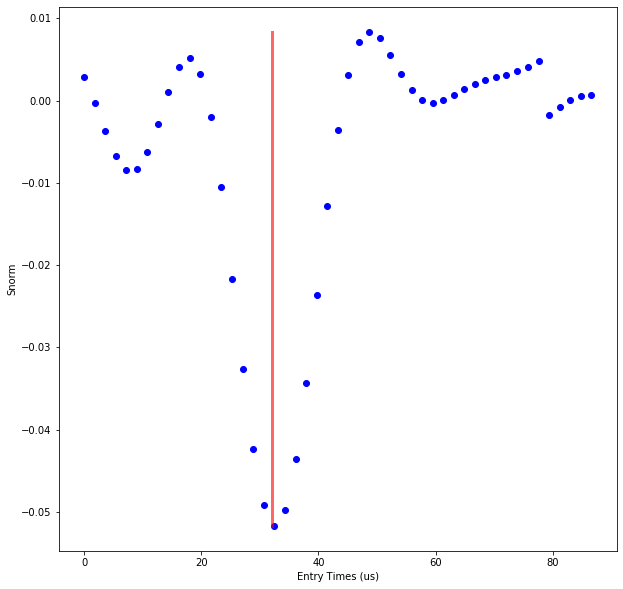

In [19]:
# Entry Time vs. S w/ Noise

# The X_val and Y_val in these plotting cells provide the red line showing the truth of the monte carlo

X_Val = [(n_pad_strt - 1) * tnsMS_ms, (n_pad_strt - 1) * tnsMS_ms]
Y_Val = [-min(S), -max(S)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig1 = plt.figure(figsize=[10,10])
plt.plot(np.array(tm_strt_plt) * s_ms, -np.array(S), 'bo', alpha=1) # Input variable as the X axis & S or Snorm for the y axis
plt.plot(X_Val, Y_Val, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Entry Times (us)')
plt.show()

C:\Users\bahaa\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\bahaa\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


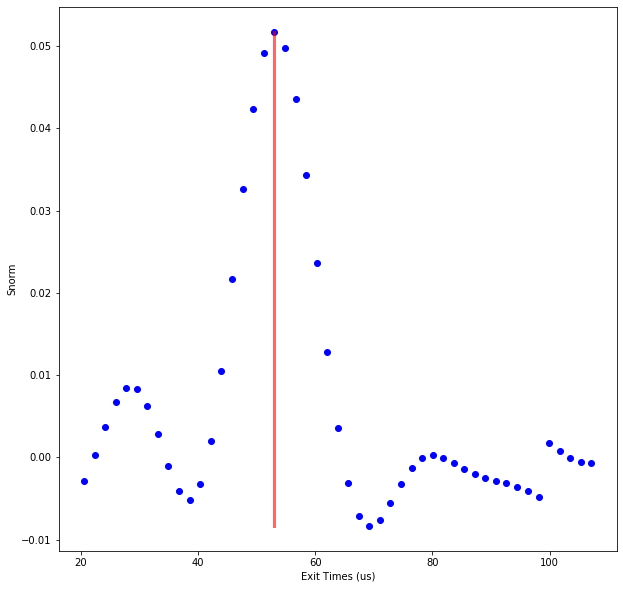

In [20]:
# Exit Time vs. S w/ Noise

X_Val = [(len(time) - n_pad_end) * tnsMS_ms, (len(accels_noise[0]) - n_pad_end - lin_resp_len + 1) * tnsMS_ms]
Y_Val = [min(S), max(S)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig3 = plt.figure(figsize=[10,10])
plt.plot(np.array(tm_end_plt) * s_ms, S, 'bo', alpha=1) # Input variable as the X axis & S or Snorm for the y axis
plt.plot(X_Val, Y_Val, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Exit Times (us)')
plt.show()


In [21]:
def wrapper_diff_tm(alpha_def, theta_entry, phi_entry, theta_exit, phi_exit, accels=accels, lin_resp=lin_resp, sensors_pos=sensors_pos):
    S = []
    S_norm = []
        
    timestep_indices = np.array([np.int(np.argmin(np.abs(time-(t_0 * s_ns))))])
    t_0_op = time[timestep_indices] / s_ns
    
    d_t_op = alpha_def[0] * scl_fct
    
    theta_entry_op, phi_entry_op, theta_exit_op, phi_exit_op = theta_entry, phi_entry, theta_exit, phi_exit
    
    x_0 = radius * np.sin(theta_entry_op) * np.cos(phi_entry_op)
    y_0 = radius * np.sin(theta_entry_op) * np.sin(phi_entry_op)
    z_0 = radius * np.cos(theta_entry_op)
        
    x_1 = radius * np.sin(theta_exit_op) * np.cos(phi_exit_op)
    y_1 = radius * np.sin(theta_exit_op) * np.sin(phi_exit_op)
    z_1 = radius * np.cos(theta_exit_op)


    t_0_eff = t_0_op - t_0_op
    t_1_eff = np.float(d_t_op) / s_ns
    
    alpha_pair = np.array([[float(x_0),
                           float(y_0),
                           float(z_0),
                           float(t_0_eff),
                           float(x_1),
                           float(y_1),
                           float(z_1),
                           float(t_1_eff)]])
    
    timesteps=t_0_op
                
    transformed_data = pint.transform(time/s_ns, accels_noise, timesteps, timestep_indices, alpha_pair, sensors_pos, lin_resp)
    
    # NOTE: The time components of transformed data are coming out in 100's of seconds (i.e. divide by 100 and the units would be seconds)
    
    return transformed_data
    #return -transformed_data['S_norm']

In [22]:
t_diff_vals = np.linspace(0, 5, num_pts) # 100s of thousandths of Seconds (Microseconds / 10 or, more premenantly, nanoseconds*scl_fct)
S_diff = []
tm_end_plt_diff = []
tm_strt_plt_diff = []
for m in t_diff_vals:
    c = wrapper_diff_tm(np.array([m]), theta_entry, phi_entry, theta_exit, phi_exit)
    for z in range(0, len(c)):
        tm_strt_plt_diff.append(np.array(c['alpha0_t'][z]))
        tm_end_plt_diff.append(np.array(c['alpha1_t'][z]))
        S_diff.append(np.array(c['S_norm'][z]))

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\bahaa\anaconda3\lib\site-packages\planckanalysis\integral_transform.py:205: RuntimeWarning: divide by zero encountered in true_divide
  dir_vector_step = dir_vector / (alpha_pair[7] - alpha_pair[3]) * adc_timestep_size
100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


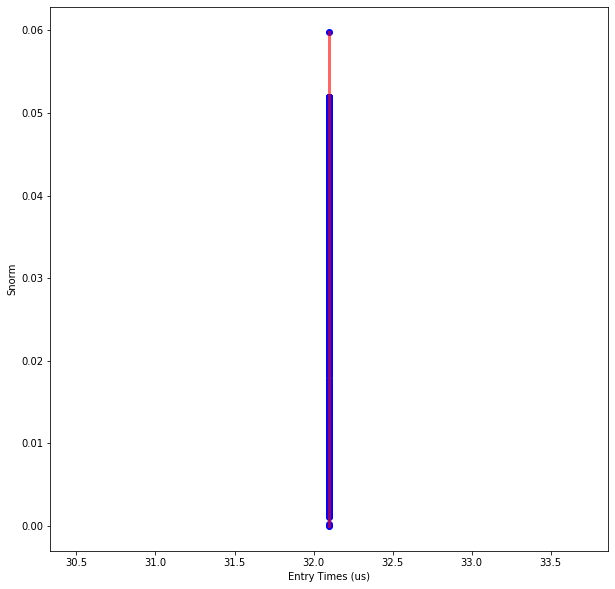

In [23]:
# Exit Time vs. S w/ Noise

X_Val = [(n_pad_strt - 1) * tnsMS_ms, (n_pad_strt - 1) * tnsMS_ms]
Y_Val = [min(S_diff), max(S_diff)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig3 = plt.figure(figsize=[10,10])
plt.plot(np.array(tm_strt_plt_diff) * s_ms, S_diff, 'bo', alpha=1) # Input variable as the X axis & S or Snorm for the y axis
plt.plot(X_Val, Y_Val, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Entry Times (us)')
plt.show()

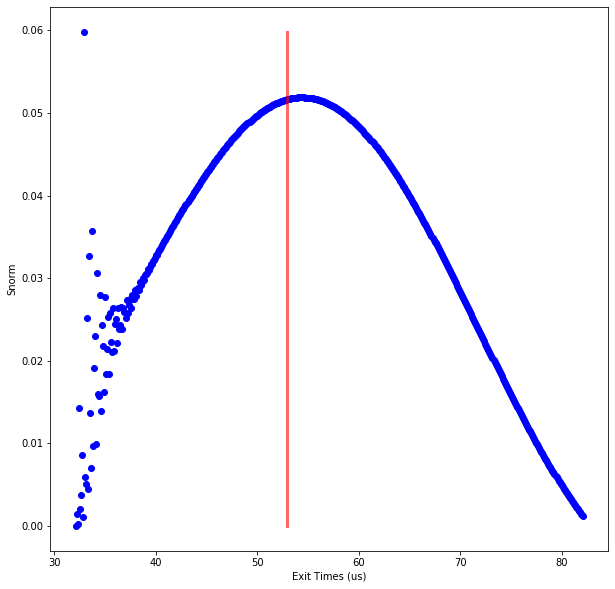

In [24]:
# Exit Time vs. S w/ Noise

X_Val = [(len(time) - n_pad_end) * tnsMS_ms, (len(accels_noise[0]) - n_pad_end - lin_resp_len + 1) * tnsMS_ms]
Y_Val = [min(S_diff), max(S_diff)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig3 = plt.figure(figsize=[10,10])
plt.plot(np.array(tm_end_plt_diff) * s_ms, S_diff, 'bo', alpha=1) # Input variable as the X axis & S or Snorm for the y axis
plt.plot(X_Val, Y_Val, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Exit Times (us)')
plt.show()

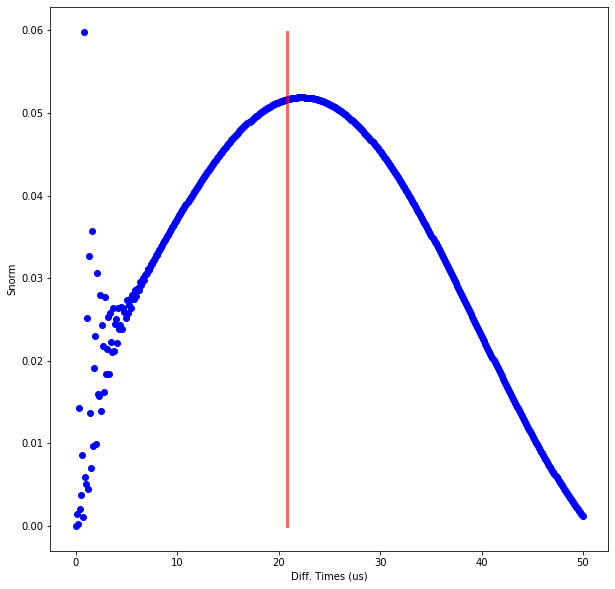

In [25]:
# Time Difference vs. S w/ Noise

X_Val = [(len(time) - n_pad_end) * tnsMS_ms - (n_pad_strt - 1) * tnsMS_ms, (len(accels_noise[0]) - n_pad_end - lin_resp_len + 1) * tnsMS_ms - (n_pad_strt - 1) * tnsMS_ms]
Y_Val = [min(S_diff), max(S_diff)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig3 = plt.figure(figsize=[10,10])
plt.plot((np.array(tm_end_plt_diff) - np.array(tm_strt_plt_diff)) * s_ms, S_diff, 'bo', alpha=1)
plt.plot(X_Val, Y_Val, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Diff. Times (us)')
plt.show()

In [26]:
def wrapper_sp3D(alpha_def, accels=accels, lin_resp=lin_resp, sensors_pos=sensors_pos):
    S = []
    S_norm = []
        
    timestep_indices = np.array([np.int(np.argmin(np.abs(time-(t_0 * s_ns))))])
    t_0_op = time[timestep_indices] / s_ns
        
    theta_entry_op, phi_entry_op, theta_exit_op, phi_exit_op, d_t_op = alpha_def[0], phi_entry, alpha_def[1], phi_exit, d_t * s_ns
    
    
    x_0 = radius * np.sin(theta_entry_op) * np.cos(phi_entry_op)
    y_0 = radius * np.sin(theta_entry_op) * np.sin(phi_entry_op)
    z_0 = radius * np.cos(theta_entry_op)
        
    x_1 = radius * np.sin(theta_exit_op) * np.cos(phi_exit_op)
    y_1 = radius * np.sin(theta_exit_op) * np.sin(phi_exit_op)
    z_1 = radius * np.cos(theta_exit_op)


    t_0_eff = t_0_op - t_0_op
    t_1_eff = np.float(d_t_op) / s_ns
    
    alpha_pair = np.array([[float(x_0),
                           float(y_0),
                           float(z_0),
                           float(t_0_eff),
                           float(x_1),
                           float(y_1),
                           float(z_1),
                           float(t_1_eff)]])
    
    timesteps=t_0_op
            
    transformed_data = pint.transform(time/s_ns, accels_noise, timesteps, timestep_indices, alpha_pair, sensors_pos, lin_resp)
    
    # NOTE: The time components of transformed data are coming out in 100's of seconds (i.e. divide by 100 and the units would be seconds)
    
    return transformed_data

In [27]:
# Make sure output of wrapper is 'return transformed_data', and return it back to 'return -transformed_data['S_norm']' for the optimizer

# The loop below can be expanded to all entry and exit angles

phis = np.linspace(-np.pi, np.pi, 15)
thetas = np.linspace(0, np.pi, 5)
S_sp = []
tm_end_plt_diff = []
tm_strt_plt_diff = []
theta_plt_noise_entry = []
phi_plt_noise_entry = []
theta_plt_noise_exit = []
phi_plt_noise_exit = []
for a in thetas:
    for b in thetas:
        if a != b:
            e = wrapper_sp3D(np.array([a, b]))
            for z in range(0, len(e)):
                theta_plt_noise_entry.append(a * 180 / np.pi)
                theta_plt_noise_exit.append(b * 180 / np.pi)
                tm_strt_plt_diff.append(np.array(e['alpha0_t'][z]))
                tm_end_plt_diff.append(np.array(e['alpha1_t'][z]))
                S_sp.append(np.array(e['S_norm'][z]))
                #print(e['S_norm'][z])

100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


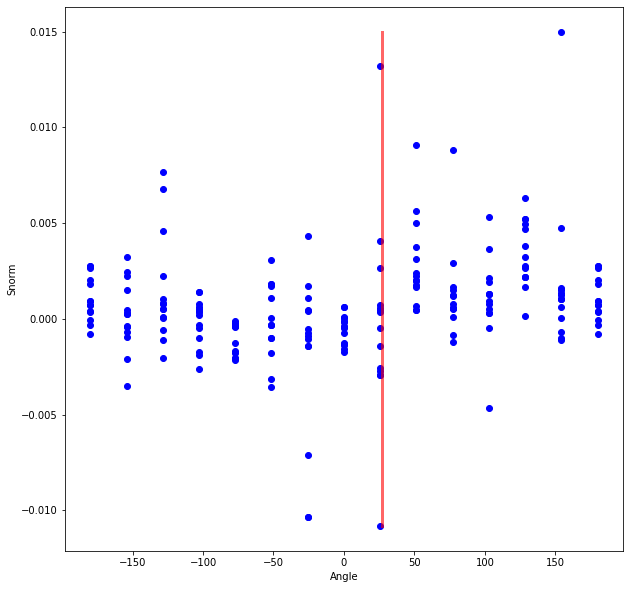

In [28]:
# Angle in degrees vs. S w/ Noise

X_Val1 = [theta_entry* 180 / np.pi, theta_entry* 180 / np.pi]
Y_Val1 = [min(S_sp), max(S_sp)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_plt_noise_entry, S_sp, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Angle (deg)')
plt.show()

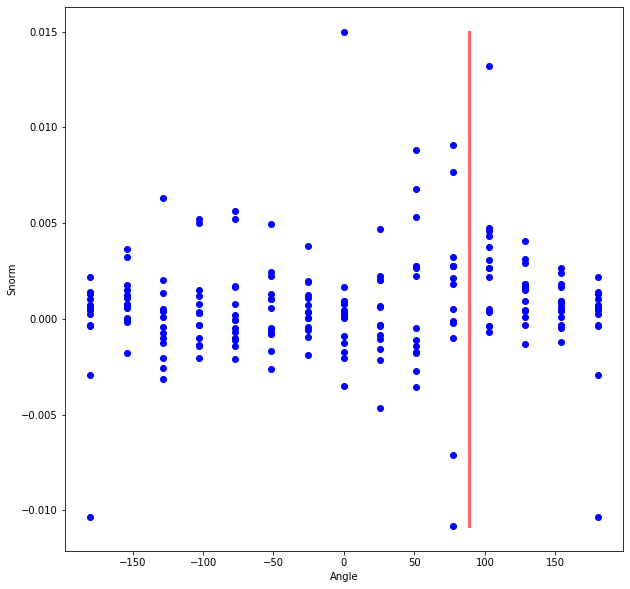

In [29]:
# Angle in degrees vs. S w/ Noise

X_Val1 = [theta_exit* 180 / np.pi, theta_exit* 180 / np.pi]
Y_Val1 = [min(S_sp), max(S_sp)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_plt_noise_exit, S_sp, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Angle (deg)')
plt.show()